# Testing Production Model
* This notebook is create to experiment with and test the production model that we created. 
* Even though the model was created using best params that we got from training and validation step, it is failing to predict the classes correctly. 
* In this notebook we'll experiment with different data and try to debut the issue. 

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import joblib
from pathlib import Path
from sklearn.metrics import ConfusionMatrixDisplay

import sys

In [2]:
# Add the root directory of your project to the Python path
root_dir = Path("..").resolve()
if root_dir not in sys.path:
    sys.path.append(str(root_dir))

## Import Data

In [3]:
data_path = Path("..", "data")
mnist_train_set = pd.read_csv(Path(data_path, "mnist_train_set.csv"))
mnist_test_set = pd.read_csv(Path(data_path, "mnist_test_set.csv"))

In [4]:
mnist_train_set.shape

(56000, 785)

In [5]:
mnist_test_set.shape

(14000, 785)

### Split Data in features and target

In [6]:
## split the data into features and target
train_X = mnist_train_set.drop("class", axis=1)
train_Y = mnist_train_set["class"]

test_X = mnist_test_set.drop("class", axis=1)
test_Y = mnist_test_set["class"]

## Load Model

In [7]:
## load model from api/models/svc_prod.joblib
model_path = Path("..", "models", "svc_prod.joblib")
print(f"Loading model from {model_path}")
model = joblib.load(str(model_path))

Loading model from ../api/models/svc_prod.joblib


## Load Utility Functions

In [8]:
from api.utils.performance_metrics import update_model_comparison

## Validating Against Test Data

In [9]:
probabilites = model.predict_proba(test_X)

Normalizing data...


In [10]:
performance_metrics = update_model_comparison(probabilites, test_Y, "svc_prod", "prod", "svc_prod.joblib")

In [11]:
performance_metrics

,Algorithm,Method,File Name,Accuracy,Weighted F1 Score,ROC AUC Score,Class_0,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8,Class_9
0,svc_prod,prod,svc_prod.joblib,0.984214,0.98421,0.999732,0.991004,0.989534,0.984615,0.984561,0.981229,0.982526,0.988731,0.980473,0.982765,0.975994


In [12]:
## confusion matrix
predictions = np.argmax(probabilites, axis=1)

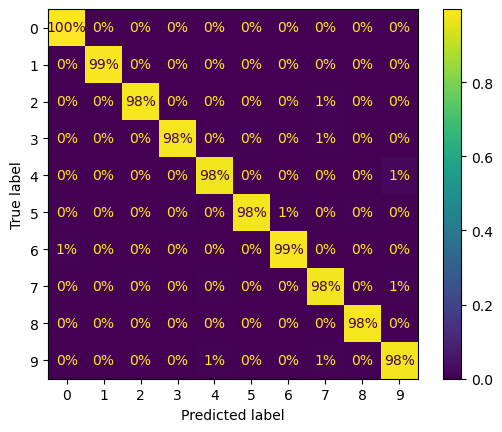

In [13]:
ConfusionMatrixDisplay.from_predictions(test_Y, predictions, normalize="true", values_format=".0%")

Observations:
* So it seems to be doing well, with test data. 
* Problem could be that the input we are getting from frontend is not in the right format or processed correctly. 
    * Lets collect samples from frontend, save it as csv, and then use it to verify the performance. 
    * This will require some changes in API and frontend. 

## Validating Against User Input

* We want to validate 2 things here, 
    * We are capturing the right user input, which means we'll need to render the captured input and check if all digits render as drawn
    * We are predicting it correctly or not. 

### Reading User Input

In [14]:
user_input_set = pd.read_csv(Path(data_path, "user_input.csv"))

In [15]:
user_input_set.shape

(10, 785)

In [16]:
## split into features and target
user_input_X = user_input_set.drop("class", axis=1)
user_input_Y = user_input_set["class"]

In [17]:
import random

from matplotlib import pyplot as plt


def render_specific_misclassified_images(features, actual_classes):
    """
    Renders random images where a specific digit was misclassified as another digit.

    Args:
        features (pd.DataFrame or np.ndarray): The feature dataset (e.g., pixel intensities).
        actual_classes (pd.Series or np.ndarray): The actual class labels.
        predictions (np.ndarray): The predicted class labels.
        actual_digit (int): The actual digit (e.g., 1 if you want to find misclassified 1s).
        predicted_digit (int): The predicted digit (e.g., 2 if you want to see where 1s were misclassified as 2s).
        num_images (int): Number of images to render. Default is 5.
    """
    # Ensure inputs are in NumPy array format
    features = np.array(features)
    actual_classes = np.array(actual_classes)
    # predictions = np.array(predictions)

    # Find the indices where the actual digit was misclassified as the predicted digit
    # specific_misclassified_indices = np.where((actual_classes == actual_digit) & (predictions == predicted_digit))[0]

    # if len(specific_misclassified_indices) == 0:
    #     print(f"No instances found where digit {actual_digit} was misclassified as {predicted_digit}.")
    #     return

    # Randomly select indices to display
    # selected_indices = random.sample(list(specific_misclassified_indices), min(num_images, len(specific_misclassified_indices)))
    selected_indices = range(features.shape[0])
    # Plot the images
    plt.figure(figsize=(10, 20))
    for i, idx in enumerate(selected_indices):
        plt.subplot(1, 10, i + 1)
        plt.imshow(features[idx].reshape(28, 28), cmap="gray")
        # plt.title(f"True: {actual_classes[idx]}, Pred: {predictions[idx]}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

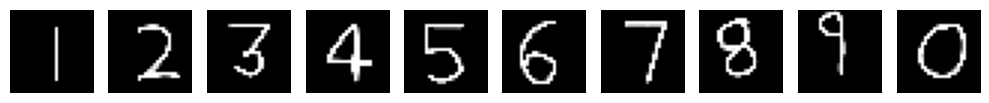

In [18]:
render_specific_misclassified_images(user_input_X, user_input_Y)

Observations:
* So after making some fixes in front-end we are capturing the use drawn digits correctly. 
* Lets test this using our model and see what the predictions are

In [19]:
model.predict(user_input_X)

Normalizing data...


array([1, 2, 3, 4, 5, 5, 2, 3, 7, 0])

In [20]:
user_input_X

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
probabilites = model.predict_proba(user_input_X)

Normalizing data...


In [22]:
predictions = np.argmax(probabilites, axis=1)

In [23]:
user_metrics = update_model_comparison(probabilites, user_input_Y, "svc_prod", "prod", "svc_prod.joblib")

In [24]:
user_metrics

,Algorithm,Method,File Name,Accuracy,Weighted F1 Score,ROC AUC Score,Class_0,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8,Class_9
0,svc_prod,prod,svc_prod.joblib,0.6,0.5,0.955556,1.0,1.0,0.666667,0.666667,1.0,0.666667,0.0,0.0,0.0,0.0


Observations:
* So it seems the model is predicting the user input, the accuracy could be low because our sample size is very small, but it is predicting various numbers unlike in prod. 
* Lets capture the input we get in `predict` calls and try to predict the class here. In production all API requests are predicting 1. 

In [114]:
prediction_request_set = pd.read_csv(Path(data_path, "user_prediction_request.csv"))

In [115]:
prediction_request_set.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [116]:
prediction_request_set.shape

(1, 784)

In [117]:
prediction_request_set.min().max()

255.0

In [118]:
model.predict(prediction_request_set)

Normalizing data...


array([1])

Observation: 
* So the model here is predicting correctly, but the same model in API is predicting all 1s for the same input. 

In [119]:
model.predict_proba(prediction_request_set)

Normalizing data...


array([[0.01216169, 0.6160863 , 0.01629567, 0.00967029, 0.01120753,
        0.19109795, 0.0334273 , 0.09324653, 0.00199456, 0.01481217]])

## More Debugging